# Hypothesis Testing Simulation
### Objective: Simulate A/B testing to understand the effects of different variables on user engagement.

In [326]:
# import needed packages
import numpy as np
import pandas as pd
import random
from scipy import stats
from scipy.stats import t
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [262]:



# Define neccessary parameters
number_of_users_in_group = 1000 # This would be the number of users in each group or column


# 1. Generate random dataset

In [263]:
def generate_table(seed, num_rows=1000):
    """Generates Pandas DataFrame with click, time_spent, and conversion columns.

    Args:
        num_rows: The number of rows in the DataFrame.

    Returns:
        Pandas DataFrame.
    """

    # To generate random boolean values for 'click' and 'conversion'
    # since the code is to be shared i will set a seed to have a consistent starting point so the code would generate the same set of values when run again
    np.random.seed(seed)
    
    # Generate two random values (for True and False)
    random_probs = np.random.rand(2)

    # Normalize to make the sum of probabilities equal to 1
    random_probs /= random_probs.sum()
    
    click = np.random.choice([True, False], size=num_rows, p=random_probs)
    conversion = np.random.choice([True, False], size=num_rows, p=random_probs)

    # Generate random time spent values in minutes (between 0 and 420 for example)
    # https://www.researchgate.net/figure/Time-spent-for-online-shopping-N168_tbl2_330237934
    time_spent = np.random.randint(5, 420, size=num_rows)  # Generates integers between 0 and 60 inclusive.

    # Create a DataFrame with generated values
    df = pd.DataFrame({
        'click': click,
        'time_spent (min)': time_spent,
        'conversion': conversion
    })

    return df

In [264]:
# Generating random control and treatment datasets
df_control = generate_table(45)
df_treatment = generate_table(1)

In [265]:
df_control.head()

,click,time_spent (min),conversion
0,True,95,True
1,True,373,True
2,True,294,True
3,True,47,True
4,True,206,True


In [266]:
df_treatment.head()

,click,time_spent (min),conversion
0,True,297,False
1,True,309,False
2,True,392,False
3,True,122,True
4,True,248,True


# 2. Datacleaning - Align conversion with click

In [267]:
# backup generated data
df_control_backup = df_control.copy() # backup control dataset
df_treatment_backup = df_treatment.copy() # backup treatment dataset

In [268]:
df_control_copy = df_control.copy()

In [269]:
# in order to prevent a situation where click is false and conversion is true as a user would need to click before conversion can occur
# clean dataset
def align_click_with_conversion(df):
    df['conversion'] = np.where(df['click'] == False, False, df['conversion'])
    return df
        

In [270]:
df_control = align_click_with_conversion(df_control) # remove contradiction in control dataset
df_treatment = align_click_with_conversion(df_treatment) # remove contradiction in treatment dataset

In [271]:
df_control.head()

,click,time_spent (min),conversion
0,True,95,True
1,True,373,True
2,True,294,True
3,True,47,True
4,True,206,True


In [272]:
df_control['click'].mean()

0.651

In [273]:
df_control['click'].value_counts()

click
True     651
False    349
Name: count, dtype: int64

In [274]:
# add id column to dataframe
df_control['id'] = 'control'
df_treatment['id'] = 'treatment'

In [275]:
# concat two control and treatment dataframe to create one Coker_AB dataframe
coker_AB = pd.concat([df_control, df_treatment])

In [276]:
# check shape of created dataframe
coker_AB.shape

(2000, 4)

In [277]:
coker_AB.head()

,click,time_spent (min),conversion,id
0,True,95,True,control
1,True,373,True,control
2,True,294,True,control
3,True,47,True,control
4,True,206,True,control


### save generated dataframe to csv

In [278]:
coker_AB.to_csv('/Users/strangemax/Library/Mobile Documents/iCloud~AsheKube~Carnets/Documents/Alt/alt/pablo data/coker_AB.csv', index=False)

In [279]:
# read data from csv
ab_test = pd.read_csv('/Users/strangemax/Library/Mobile Documents/iCloud~AsheKube~Carnets/Documents/Alt/alt/pablo data/coker_AB.csv')

## exploratory data analysis

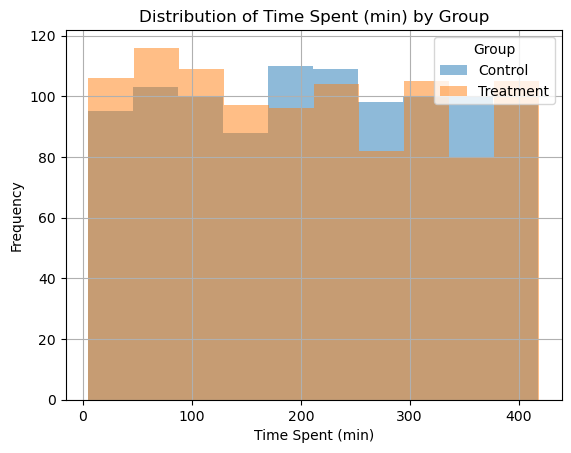

In [327]:
ab_test.groupby('id')['time_spent (min)'].hist(alpha=0.5, legend=True)

# Set the legend
plt.legend(title='Group', labels=['Control', 'Treatment'])

# Set the title and labels
plt.title('Distribution of Time Spent (min) by Group')
plt.xlabel('Time Spent (min)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

<Axes: xlabel='id', ylabel='conversion'>

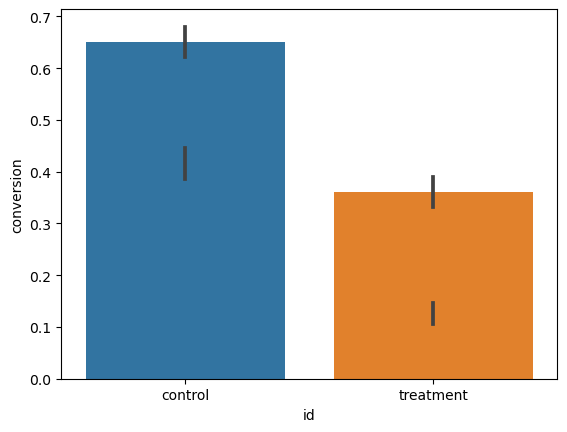

In [319]:
sns.barplot(x='id', y='click', data=ab_test)
sns.barplot(x='id', y='conversion', data=ab_test)

<Axes: xlabel='id', ylabel='time_spent (min)'>

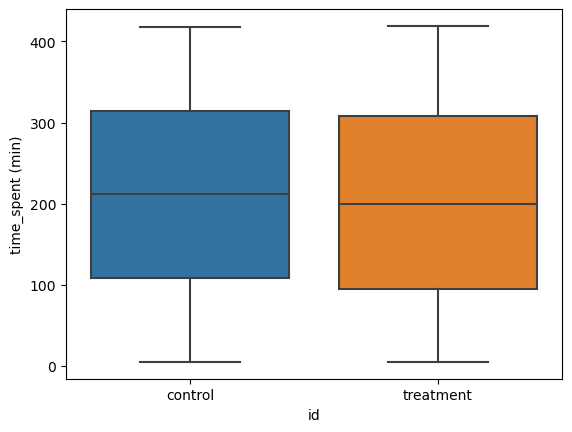

In [321]:
sns.boxplot(x='id', y='time_spent (min)', data=ab_test)

In [324]:
ab_test[['time_spent (min)', 'click', 'conversion']].corr()

,time_spent (min),click,conversion
time_spent (min),1.000000,0.049953,-0.001210
click,0.049953,1.000000,0.601671
conversion,-0.001210,0.601671,1.000000


# Hypothesis testing

In [280]:
ab_test.head()

,click,time_spent (min),conversion,id
0,True,95,True,control
1,True,373,True,control
2,True,294,True,control
3,True,47,True,control
4,True,206,True,control


In [ ]:
# function to calculate rate for control and treatment
def calculate_rate(df, test_col, identifier):
    sum = 0
    for i in ab_test[ab_test['id'] == identifier][test_col]:
        if i == True:
            sum += 1
    ctr = sum / len(ab_test[ab_test['id'] == identifier])
    return ctr

## ctr_control_test = ab_test[ab_test['id'] == 'control']['click'].mean() #alternate method

In [ ]:
# calculate clickthrough rate
ctr_control = calculate_rate(ab_test, 'click', 'control') # calculate clickthrough rate for control
ctr_treatment = calculate_rate(ab_test, 'click', 'treatment') # calculate clickthrough rate for treatment
ctr_control, ctr_treatment


(0.651, 0.361)

In [ ]:
# calculate conversion rate
cr_control = calculate_rate(ab_test, 'conversion', 'control') # calculate conversion rate for control
cr_treatment = calculate_rate(ab_test, 'conversion', 'treatment') # calculate conversion rate for treatment
cr_control, cr_treatment

(0.416, 0.125)

In [297]:
# average time spent
ts_control_avg = ab_test[ab_test['id'] == 'control']['time_spent (min)'].mean()
ts_treatment_avg = ab_test[ab_test['id'] == 'treatment']['time_spent (min)'].mean()
ts_control_avg, ts_treatment_avg

(211.969, 204.998)

#  run a 2-proportion z-test using statsmodels:

In [293]:
def two_proportion_z_test(successes, totals, alpha=0.05):
    """
    Perform a two-proportion z-test to compare the proportions of two groups.
    
    Parameters:
    - successes: List of successes in each group.
    - totals: List of total trials in each group.
    - alpha: Significance level (default is 0.05).
    
    Returns:
    - A message indicating whether to reject or fail to reject the null hypothesis.
    """
    # Perform the z-test
    z_stat, p_value = sm.stats.proportions_ztest(successes, totals)

    # Print the z-statistic and p-value
    print(f"Z-statistic: {z_stat}")
    print(f"P-value: {p_value}")

    # Determine if we reject the null hypothesis
    if p_value < alpha:
        print("Reject the null hypothesis (statistically significant).")
    else:
        print("Fail to reject the null hypothesis (not statistically significant).")

## 2-proportion z-test for click through rate

In [294]:
ctr_successes = [651, 361]
totals = [1000, 1000]

two_proportion_z_test(ctr_successes, totals)

Z-statistic: 12.970128152346746
P-value: 1.8072793011737103e-38
Reject the null hypothesis (statistically significant).


## 2-proportion z-test for conversion

In [295]:
ctr_successes = [416, 125]
totals = [1000, 1000]

two_proportion_z_test(ctr_successes, totals)

Z-statistic: 14.648113901616435
P-value: 1.3850740997781642e-48
Reject the null hypothesis (statistically significant).


## 2-proportion z-test for time spent

In [302]:

ts_control = np.array(ab_test[ab_test['id'] == 'control']['time_spent (min)'])
ts_treatment = np.array(ab_test[ab_test['id'] == 'treatment']['time_spent (min)'])

t_stat, p_value = stats.ttest_ind(ts_control, ts_treatment)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Set alpha (significance level)
alpha = 0.05

# Determine if we reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis (statistically significant change).")
else:
    print("Fail to reject the null hypothesis (no significant change).")

T-statistic: 1.3037083974846926
P-value: 0.19248321510492067
Fail to reject the null hypothesis (no significant change).


# calculate effect size

In [304]:
# function to calculate effect sizes
def effect_size(control, treatment):
    """
    Calculate the absolute and relative effect sizes based on the control and treatment group data.

    Parameters:
    - control: List or array of values from the control group.
    - treatment: List or array of values from the treatment group.

    Returns:
    - A tuple containing the absolute effect size and relative effect size.
    """
    
    # Calculate Absolute Effect Size
    absolute_effect_size = treatment - control
    
    # Calculate Relative Effect Size
    relative_effect_size = absolute_effect_size / control if control != 0 else np.nan

    print(f"Absolute Effect Size: {absolute_effect_size}")
    print(f"Relative Effect Size: {relative_effect_size}")

In [305]:
# effect size for clip through rate
effect_size(ctr_control, ctr_treatment)

Absolute Effect Size: -0.29000000000000004
Relative Effect Size: -0.44546850998463905


In [306]:
# effect size for conversion rate
effect_size(cr_control, cr_treatment)

Absolute Effect Size: -0.291
Relative Effect Size: -0.6995192307692307


In [307]:
# effect size for time spent
effect_size(ts_control_avg, ts_treatment_avg)

Absolute Effect Size: -6.971000000000004
Relative Effect Size: -0.03288688440290799


# Confidence interval

In [312]:
def confidence_interval(control, treatment, confidence_level=0.95):
    """
    Calculate the confidence interval for the difference in means (effect size)
    between the control and treatment groups.

    Parameters:
    - control: List or array of values from the control group.
    - treatment: List or array of values from the treatment group.
    - confidence_level: The confidence level for the interval (default is 95%).

    Returns:
    - A tuple containing the lower and upper bounds of the confidence interval.
    """
    # Calculate means
    mean_control = np.mean(control)
    mean_treatment = np.mean(treatment)
    
    # Calculate standard deviations
    std_control = np.std(control, ddof=1)  # Sample standard deviation
    std_treatment = np.std(treatment, ddof=1)
    
    # Calculate sample sizes
    n_control = len(control)
    n_treatment = len(treatment)
    
    # Calculate standard error
    se = np.sqrt((std_control**2 / n_control) + (std_treatment**2 / n_treatment))
    
    # Calculate mean difference
    mean_diff = mean_treatment - mean_control
    
    # Find the Z-score for the desired confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Calculate the margin of error
    margin_of_error = z_score * se
    
    # Calculate the confidence interval
    lower_bound = mean_diff - margin_of_error
    upper_bound = mean_diff + margin_of_error
    print(f"Confidence Interval for the Effect Size: ({lower_bound}, {upper_bound})")
    # return lower_bound, upper_bound


In [313]:
# calculate CI for click through rate
ctr_control_df = ab_test[ab_test['id'] == 'control']['click']
ctr_treatment_df = ab_test[ab_test['id'] == 'treatment']['click']
confidence_interval(ctr_control_df, ctr_treatment_df)

Confidence Interval for the Effect Size: (-0.3319604595073011, -0.24803954049269902)


In [314]:
# calculate CI for click through rate
cr_control_df = ab_test[ab_test['id'] == 'control']['conversion']
cr_treatment_df = ab_test[ab_test['id'] == 'treatment']['conversion']
confidence_interval(cr_control_df, cr_treatment_df)

Confidence Interval for the Effect Size: (-0.3278072506980905, -0.25419274930190944)
